# Module 1: Introduction to Exploratory Data Analysis 

## Step 3:  Explore

In this notebook we dive into some plotting methods commonly used for Exploratory Data Analysis (EDA). 

Our [goals for EDA](http://www.itl.nist.gov/div898/handbook/eda/section1/eda11.htm) are to open-mindedly explore the data, and see what insights we may find. 

The purpose of the EDA approach is to:
- maximize insight into a data set;
- uncover underlying structure;
- extract important variables;
- detect outliers and anomalies;
- test underlying assumptions;
- develop parsimonious models; and
- determine optimal factor settings.


In this notebook we will create and examine these graphical techniques:

2. [Scatter Plot](#scatterplot)

3. [Scatter Matrix](#scattermatrix)

4. [Heat map](#heatmap)

5. [Histogram](#histogram)

6. [Bar Plot](#barplot)

7. [Box Plot](#boxplot)

8. [Time Series](#timeplot)

### Setup
<a id='setup'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("hls")
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import dateutil.parser
import re

# The command below means that the output of multiple commands in a cell will be output at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

With a fresh notebook, we read in our clean dataset again.

In [2]:
data_path = '../data/'
df = pd.read_csv(data_path+'raw_data.csv', low_memory=False)

Before diving into our exploratory data analysis, it is worth reiterating that this whole process is about understanding the distribution of data and relationships between different features.

When we move on to use machine learning algorithms, we will be asking a question and trying to answer it using the statistical relationships between different features in the data. The EDA analysis will help us shape this question and have a clear idea about how to approach building the algorithm!

With that in mind, let's look at several visualization methods to examine the data and any relationships between features...

### 1. Scatter plot
<a id='scatterplot'></a>

To start, the scatter plot! This is a very popular and powerful way to visualize the relationship between two countinuous features. Essentially this plot shows us how feature Y changes when feature X is changed. If there is a clear pattern formed in the scatter plot, we say that x and y are **correlated**. 

There are several outcomes we see on a scatter plot:
- Positive Linear = When X increases, y increases and the data points follow an approximate straight line
- Negative Linear = When X increase, y decreases and the data points follow an approximate straight line
- Non-Linear = When X increases, there is a consistent change in Y but this is not linear. It could be quadratic or exponential for example. 
- No correlation = When X increases, there is no clear pattern to how y changes, The data points form a random distribution.

Let's try this out on our data and choose two continuous variables to plot. First lets extract all the continuous variables from our dataset.

In [4]:
## Uncomment to see a list of numeric variables
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
for var in numeric_vars:
    print(var)

basket_amount
currency_exchange_loss_amount
funded_amount
id
image.id
image.template_id
journal_totals.bulkEntries
journal_totals.entries
lender_count
loan_amount
partner_id
terms.disbursal_amount
terms.loan_amount
terms.loss_liability.currency_exchange_coverage_rate
terms.repayment_term
translator.image
video.id
video.thumbnailImageId
borrower_count
partner_average_loan_size_percent_per_capita_income
partner_currency_exchange_loss_rate
partner_default_rate
partner_default_rate_note
partner_delinquency_rate
partner_delinquency_rate_note
partner_image.id
partner_image.template_id
partner_loans_at_risk_rate
partner_loans_posted
partner_portfolio_yield
partner_portfolio_yield_note
partner_profitability
partner_total_amount_raised
number_of_loans
posted_year
posted_month
time_to_fund


To start, lets look if there is a relationship between lender_count and loan_amount... intuition suggests that bigger loans much have more lenders. If this is true, we'll see this in the scatter plot!

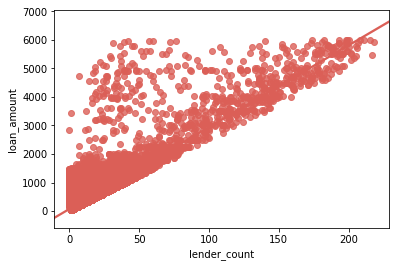

In [5]:
ax = sns.regplot(x='lender_count', y='loan_amount', data=df)

There are a few outliers which are interesting but over in general we can see that if the lender count is higher, so is the loan amount! Our intuition was correct.

Let's try one more. How about the repayment term and the loan amount? What kind of relationship would you expect between the repayment term and the loan amount?

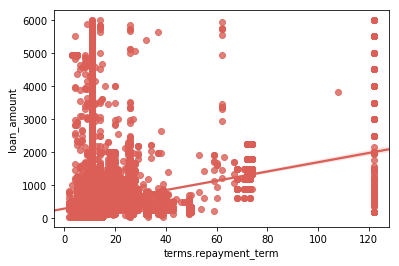

In [6]:
ax = sns.regplot(x='terms.repayment_term', y='loan_amount', data=df)

The scatter plot indicates that there is no clear relationship between the repayment term and loan amount - we wouldn't want to use repyament term to predit the loan_amount then! 

### 2. Scatter Matrix
<a id='scattermatrix'></a>

When we have lots of continuous variables, we could go through them one by one to see the relationship or we could use a scatterplot matrix! This creates a scatter plot between every combination of variables in a list. 

Another interesting quality of the scatter matrix is that the diagonals give a histogram of the variable in question. 

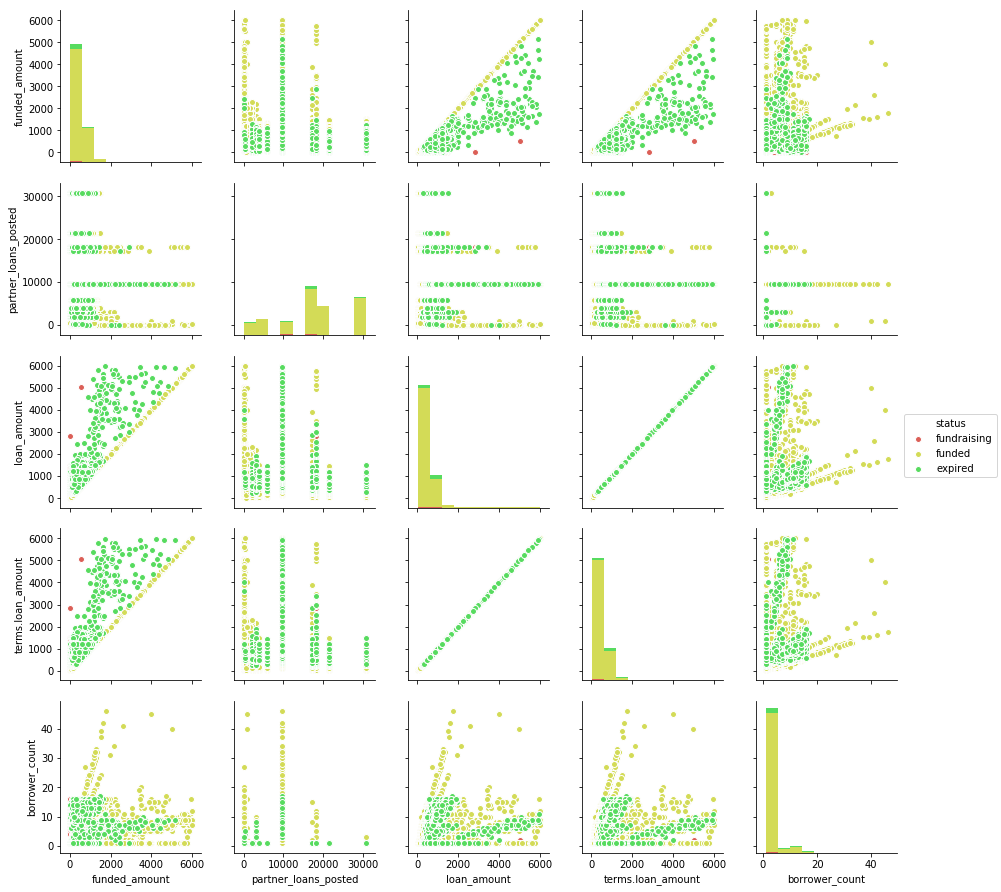

In [7]:
## Let's choose some variables to examine:
num_df = df[['funded_amount', 'partner_loans_posted', 'loan_amount', 'terms.loan_amount', 'borrower_count', 'status']];

## Remove the NaN rows so Seaborn can plot
num_df = num_df.dropna(axis=0, how='any');
# num_df.describe()

## Create the scatter plot and let's color the data point by their status.
sns.pairplot(num_df, hue = 'status');


Great! There are several useful observation we can make from this scatter matrix:
- loan amount and terms.loan_amount look exactly the same! It seems that data is duplicated in these two columns so we should only keep one to avoid issues with multucollinearity (discussed later in the linear regression notebook) and data leakage.
- Loan_amount is correlated with funded_amount
- Although partner_loans_posted is a numeric variable, it's values are clustered around certain values and there is no clear correlation with anu of the other variables. It may be better to split partner_loan_posted into several categorical variables eg partner_loans_posted < 500, 500 < partner_loan_posted < 1500, etc...
- The correlations with borrower_count are very interesting! There seems to be several linear relationship within this scatter plot and there we should investigate what is causing this!
- From the histograms, we can see the majority of the variables are clustered on the low end, with a slightly wider spread on borrower_count.

### 3. Heat Map
<a id='heatmap'></a>

Heat maps are a way of visualizing how the combination of two variables affects the value of a third. They are great to visualize when some values, or calculated values, such as averages, counts, etc. are more extreme. Let's use this is identify when large loan amounts are requested. 

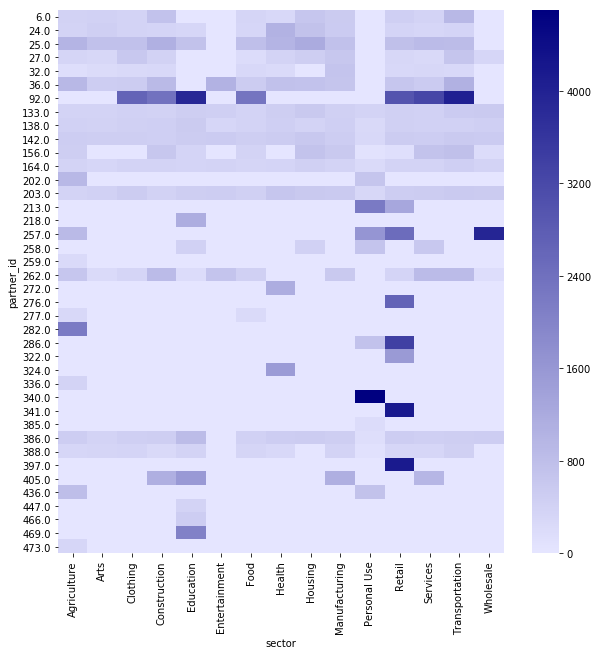

In [8]:
## Let's total up means by partner and sector
partner_sector_means = df.groupby(["partner_id", "sector"]).mean().reset_index()
partner_sector_means = partner_sector_means[["partner_id", "sector", "loan_amount"]].pivot("partner_id", "sector", "loan_amount")

## Set the color range to be friendlier by usig reset seabron color palette
my_cmap = sns.light_palette("Navy", as_cmap=True)
## Make the plt bigger
fig, ax = plt.subplots(figsize=(10,10))   
ax = sns.heatmap(partner_sector_means.fillna(0),cmap=my_cmap)

From this we can see that it's not so much the partner which leads to bigger loans but the sector. It is clear that many loans in the retail sector are bigger than the others of average!

### 4. Histogram
<a id='histogram'></a>

A histogram is useful for looking at the distribution of values for a single variable and also identifying outliers. It shows us the probability of finding data within a given range and can either be represented with bars where data is binner or as a continuous line. 

The plot below shows the data distribution of loan_amount using both bars and a continuous line. Without going into too much detail about the value on the y-axis, what we can take away from this is there is a much higher occurance of small loans (high bar/peak in the line) and that large loans are much rarer (low bars/drop in the line).

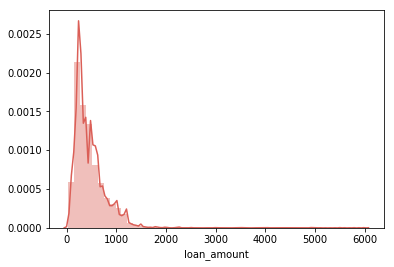

In [9]:
sns.distplot(df['loan_amount'].dropna(axis = 0))

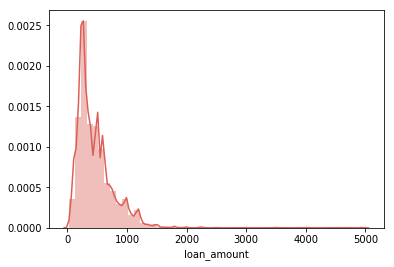

In [10]:
# Let's just look at those under 5K
small_loans_df = df[(df['loan_amount'] < 5000)]
sns.distplot(small_loans_df['loan_amount'])

Looking at the loans less than 5000 we see a much clearer distribution, although it is still left-hand skewed. 

### 5. Bar Plot
<a id='barplot'></a>

Bar plots are useful looking at hwo continuous variables changes with categoricals ones. Below we can see two bar plots, the first shows the mean loan_amount by sector and the second shows the total loan_amount by sector.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

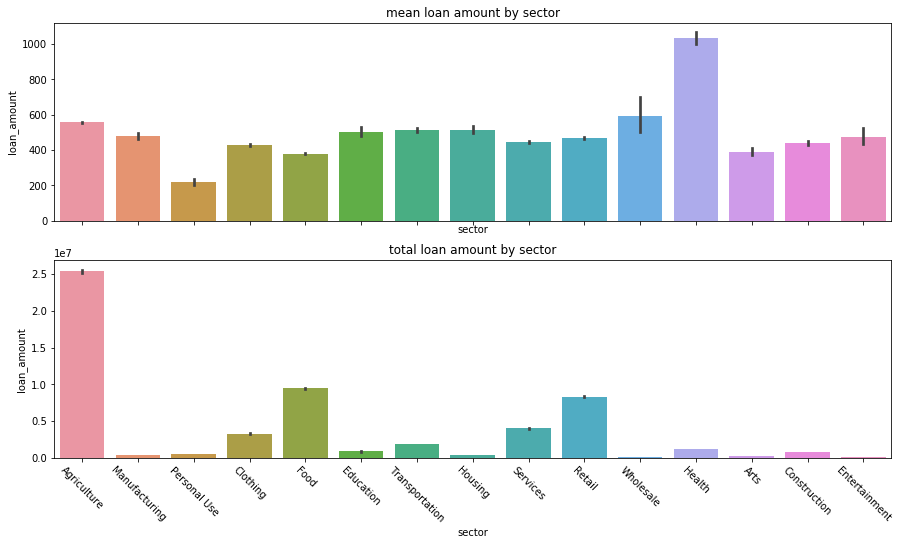

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True)
ax1.set_title("mean loan amount by sector")
ax2.set_title("total loan amount by sector")
sns.barplot(x='sector', y = 'loan_amount', data=df, estimator=np.mean, ax = ax1)
sns.barplot(x='sector', y = 'loan_amount', data=df, estimator=np.sum, ax = ax2)  
plt.xticks(rotation=-45)

This is useful as we can see although education and health have the highes loans on average, the majority of money loaned if for agriculture. 

### 6. Box Plots
<a id='boxplot'></a>

A box plot describes the distribution of data based on five important summary numebrs: the minimum, first quartile, median, third quartile, and maximum. In the simplest box plot the central rectangle spans the first quartile to the third quartile (the interquartile range or IQR). A segment inside the rectangle shows the median and "whiskers" above and below the box show the locations of the minimum and maximum. 

Lets use this to look at the distribution of borrowers counts by each sector for different loan status for different partners. First lets look at how many loans come from different partners.

In [12]:
multi_borrower_loans = df[df["borrower_count"] > 1]
multi_borrower_loans['partner_name'].value_counts()

One Acre Fund                               10347
Hand in Hand Eastern Africa                  1587
Evidence Action                               519
KOMAZA                                        204
Nuru International                            184
Opportunity International- Wedco Ltd.          56
Visionary Empowerment Programme                20
Living Goods                                   17
iSmart Kenya                                   14
Junior Achievement Kenya                       12
K-Met Savings and Credit Cooperative Ltd        7
Juhudi Kilimo                                   7
Sanergy                                         6
SMEP Microfinance Bank                          5
VisionFund Kenya                                3
PowerGen Renewable Energy                       2
BrazAfric                                       1
Paradigm Project                                1
Name: partner_name, dtype: int64

Lets just look at partners who have over 100 loans...

(array([0, 1]), <a list of 2 Text xticklabel objects>)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

(array([0]), <a list of 1 Text xticklabel objects>)

(array([0]), <a list of 1 Text xticklabel objects>)

(array([0]), <a list of 1 Text xticklabel objects>)

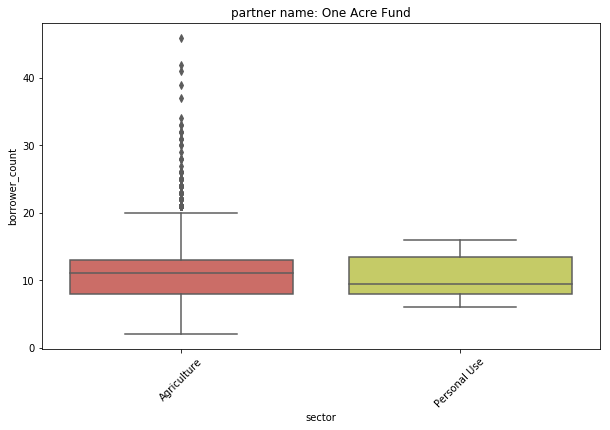

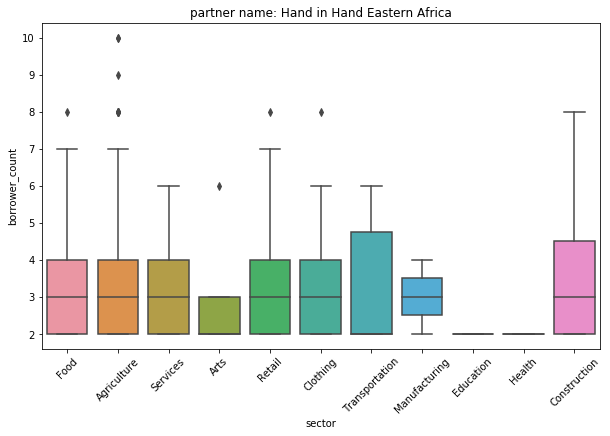

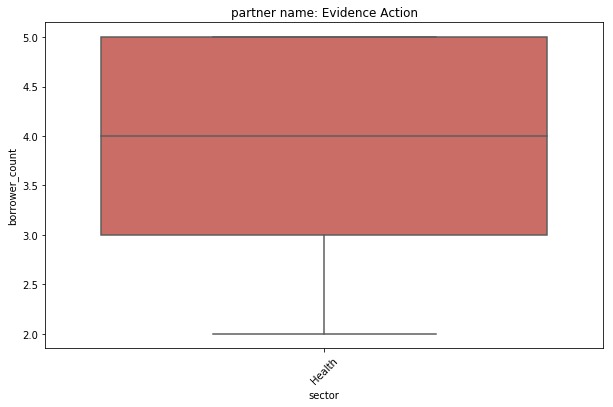

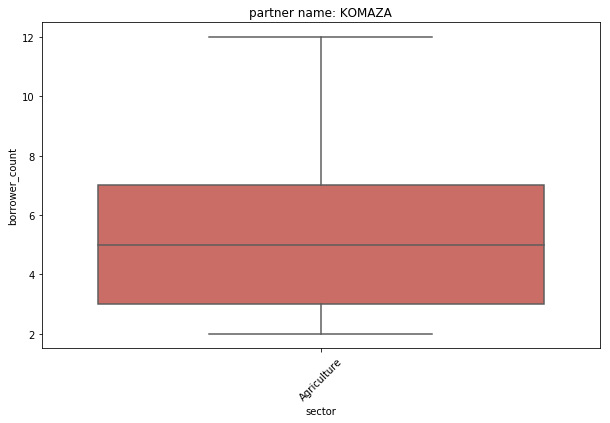

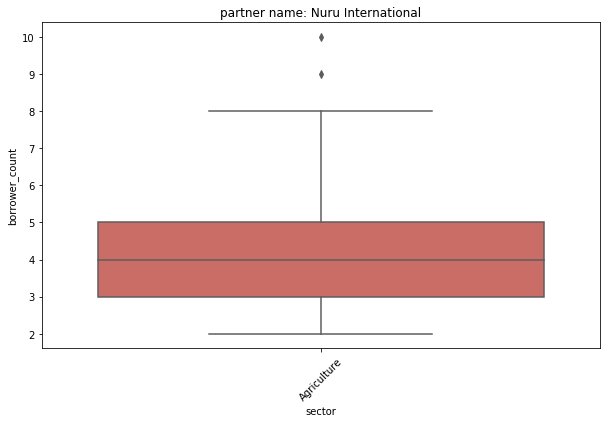

In [29]:
plt.switch_backend('agg')
top_partners = ['One Acre Fund', 'Hand in Hand Eastern Africa','Evidence Action','KOMAZA','Nuru International']
for partner in top_partners: 
    plt.figure(figsize=(10,6));
    sns.boxplot(x='sector', y='borrower_count',
                        data = multi_borrower_loans[multi_borrower_loans['partner_name']==partner][['borrower_count','sector']])
    plt.title('partner name: {}'.format(partner))
    plt.xticks(rotation=45);


This is quite interesting as we can see that on average One Acre Fund has more borrowers on each loan, we a medium around 10 - whereas the others medians are around 3 - 4. 

Also for the partners who have loans in more than one sector (hand in hand east africa and one acre fund), the distribution of loan_amount across different sectors is quite similar.

### An aside: Back to scatter plots

From the above we discovered something quite interesting... different partners have different loan characteristics - especially when considering the borrower_count. Do you remember from our scatter matrix, we noticed that loan_amount vs borrower_count showed several linear trends? let's dig into this and see if the differences we see between different partners could be responable for this.

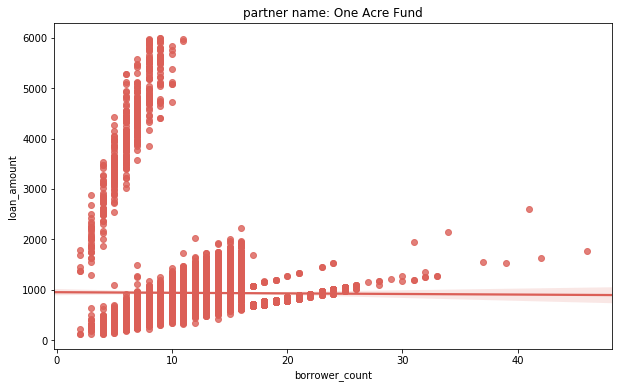

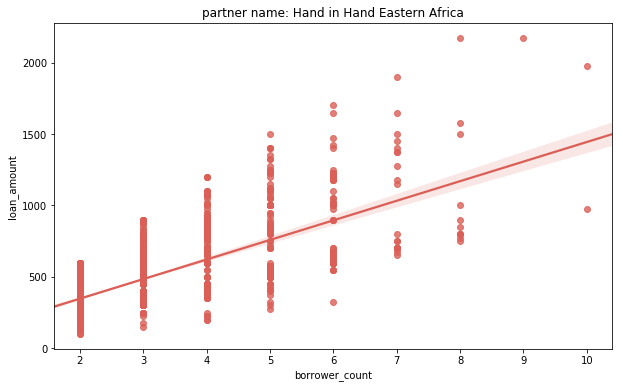

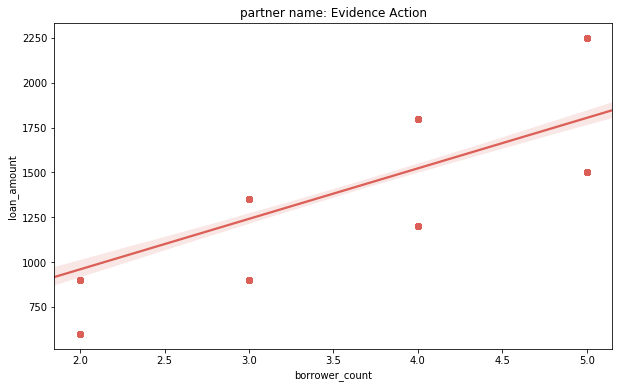

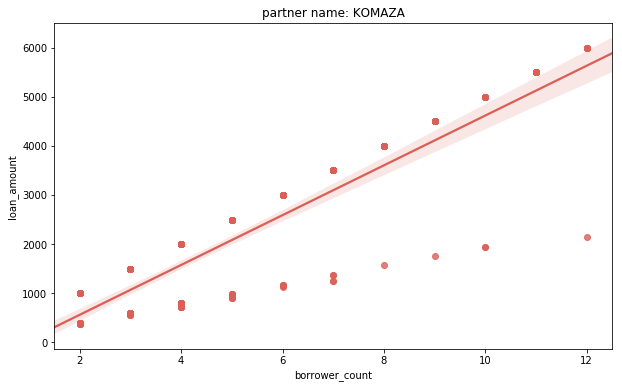

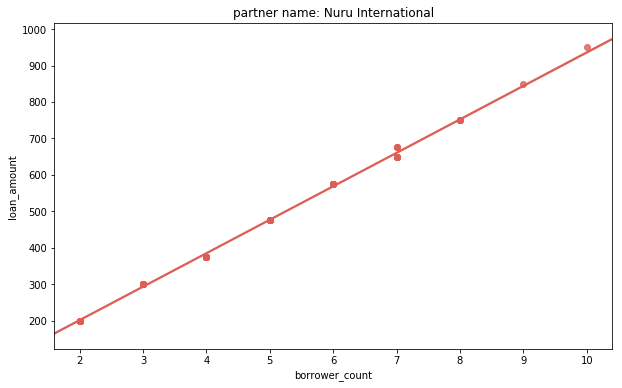

In [26]:
for partner in top_partners: 
    plt.figure(figsize=(10,6));
    sns.regplot(x='borrower_count', y='loan_amount',
                        data = multi_borrower_loans[multi_borrower_loans['partner_name']==partner][['borrower_count','loan_amount']]);
    plt.title('partner name: {}'.format(partner));


Aha! It looks like we are onto something here... we can see different trends for different partners! We'll look into this further in feature_engineering to see how we can use to create powerful features. 

### 7. Time dependancy
<a id='timeplot'></a>

Quite often it's useful to see how a variable changes over time. This means creating a plot with time on the x-axis and the variable on the y-axis.

Lets have a look at how the average loan amount changes over time on a monthly basis.

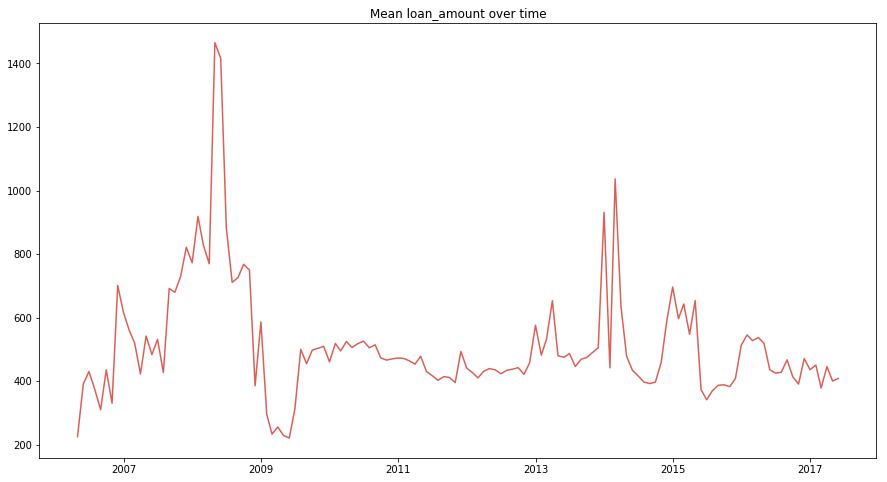

In [22]:
# Convert posted date to a datetime object
df['posted_date'] = pd.to_datetime(df['posted_date'])
# Resample the date to monthly intervals , taking the mean of loan_amount
# This creates an array where the index is the timestamp and the value is the mean of loan amount
time_data = df.resample('M', on='posted_date')['loan_amount'].mean().fillna(0)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_data)
plt.title('Mean loan_amount over time');

We can look at different timefrance by changing the parameter in resample. Lets look on a weekly basis!

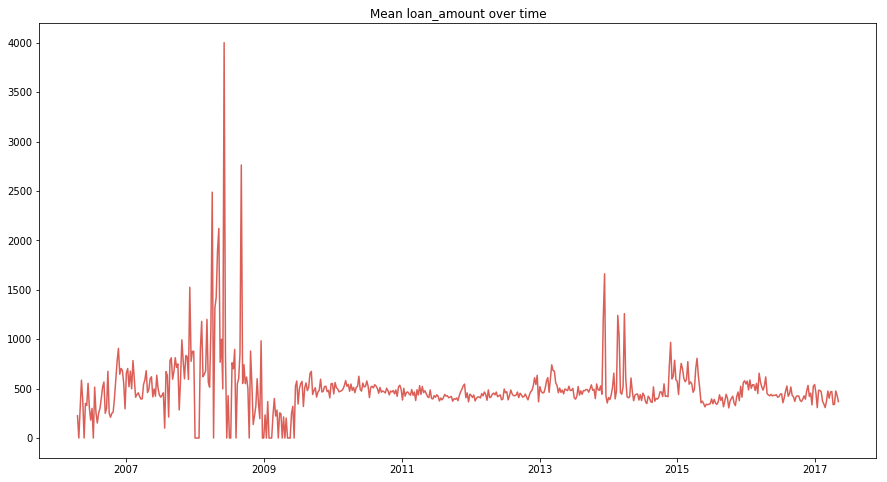

In [23]:
# Resample the date to monthly intervals , taking the mean of loan_amount
# This creates an array where the index is the timestamp and the value is the mean of loan amount
time_data = df.resample('7D', on='posted_date')['loan_amount'].mean().fillna(0)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_data)
plt.title('Mean loan_amount over time');

We cans see that the loan amount was quite erratic between 2006 and 2009, settling down to more constant value from the end of 2009 onwards with a few peaks in 2014. 

It would be interesting to see if kiva's policy changed during 2009 and whether including loans from pre-2010 in our analysis is sensible if they are no longer representative of the current situation. 

It could be quite interested to see how this graph looks if we up into different partners. There are a lot of different partners so lets just take the top five by loan_amount

In [17]:
top_five_partners = df.groupby('partner_name')['loan_amount'].sum().sort_values()[::-1][:5].index

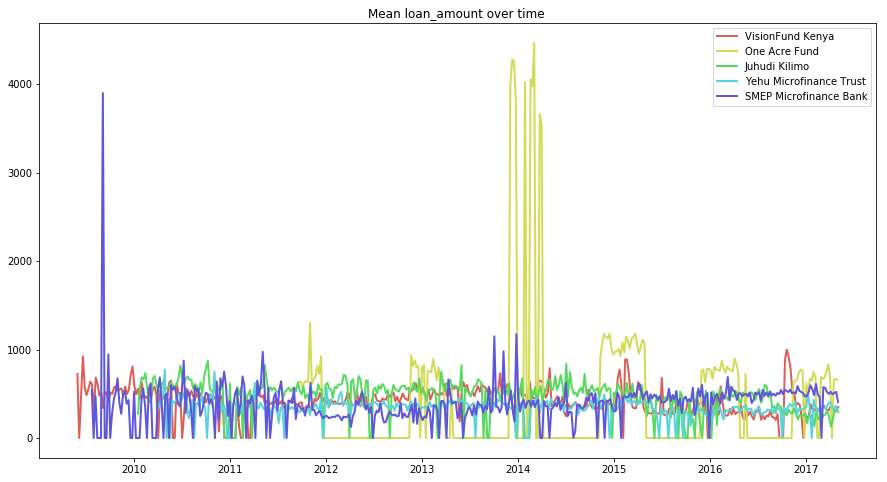

In [19]:
plt.figure(figsize=(15,8))
for partner in top_five_partners:
    time_data = df[df['partner_name']==partner].resample('7D', on='posted_date')['loan_amount'].mean().fillna(0)
    # Use seaborn plotting style
    plt.plot(time_data, label=partner, linewidth=2);
plt.title('Mean loan_amount over time ')
plt.legend(loc='best')
plt.show();

Interestingly, the top 5 partners all started operating after the erratic period in 2006-2009. we can see that the majority of the time, the loans are all around the saem amount, barring a few exceptions. One Acre Fund started asking for significantly bigger loans in 2014 and Juhudi Kilimo also shows some increases in 2014 and 2015.



### Moving on

Next we move on to feature engineering, where we create variables from what we've found!

<br>
<br> 
<br>

----